(sec-acquisitions)=


# Tutorial: Acquisitions

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Acquisitions.ipynb`
```

## Introduction

In this tutorial we give examples of how to add acquisitions to schedules, and how to retrieve acquisition results using the {class}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator`.
More specifically, this tutorial only describes acquisitions with {class}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator` with Qblox backend with transmon qubits (or Qblox backend with NV center in case of trigger count). See {ref}`sec-tutorial-schedulegettable` for a tutorial on how to perform acquisitions with {class}`~quantify_scheduler.gettables.ScheduleGettable`, and see {ref}`sec-backend-zhinst` for help on how to perform experiments with the Zurich Instruments backend.

This tutorial assumes you are familiar with compiling schedules and running simple pulses on the Qblox hardware. We also assume, that you have basic familiarity with `xarray` (see [xarray introduction](https://quantify-os.org/docs/quantify-core/dev/dev/design/dataset/Xarray%20introduction.html) and the [official documentation](https://docs.xarray.dev/en/stable/user-guide/data-structures.html)).

The basic structure of the returned acquisition data is that it is an {class}`xarray.Dataset`, which consists of multiple {class}`xarray.DataArray`. Each of these {class}`xarray.DataArray`s correspond to one acquisition channel.

Important to note, this tutorial is Qblox-specific with regard to setting up the hardware configuration and setting up the physical wiring for the hardware, but the schedules and protocols and the return data formats are backend independent.

### Initial setup

First, we set up the connection to the cluster and hardware configuration.

In [1]:
from quantify_core.data import handling as dh
dh.set_datadir(dh.default_datadir())

Data will be saved in:
/root/quantify-data


In this tutorial we will use the Qblox dummy device, but for real hardware, the ip address can be provided (without the `dummy_cfg` argument).

In [2]:
from qblox_instruments import Cluster, ClusterType
from quantify_scheduler.qblox import ClusterComponent, start_dummy_cluster_armed_sequencers

cluster = Cluster(
    "cluster0",
        identifier="<ip address>",
        dummy_cfg={
        1: ClusterType.CLUSTER_QRM,
        2: ClusterType.CLUSTER_QTM,
        3: ClusterType.CLUSTER_QCM_RF
    },
)
cluster_component = ClusterComponent(cluster)

# Temporarily fixing dummy cluster's deficiency.
cluster.start_sequencer = lambda : start_dummy_cluster_armed_sequencers(cluster_component)

In [3]:
from quantify_scheduler import BasicTransmonElement, QuantumDevice

device = QuantumDevice("device")
transmon0 = BasicTransmonElement("q0")
transmon0.clock_freqs.readout(6e9)
transmon0.clock_freqs.f01(5.8e9)
transmon0.rxy.amp180(0.325)

device.add_element(transmon0)
transmon1 = BasicTransmonElement("q1")
transmon1.clock_freqs.readout(6e9)
device.add_element(transmon1)
device.instr_instrument_coordinator("instrument_coordinator")

In [4]:
hardware_config = {
    "version": "0.2",
    "config_type": "quantify_scheduler.backends.qblox_backend.QbloxHardwareCompilationConfig",
    "hardware_description": {
        "cluster0": {
            "instrument_type": "Cluster",
            "modules": {
                "1": {
                    "instrument_type": "QRM"
                }
            },
            "ref": "internal"
        }
    },
    "hardware_options": {
        "modulation_frequencies": {
            "q0:res-q0.ro": {
                "interm_freq": 0
            },
            "q1:res-q1.ro": {
                "interm_freq": 0
            },
            "q0:mw-q0.01": {
                "interm_freq": 0
            }
        }
    },
    "connectivity": {
        "graph": [
            ["cluster0.module1.complex_output_0", "q0:res"],
            ["cluster0.module1.complex_input_0", "q0:res"],
            ["cluster0.module1.complex_output_0", "q1:res"],
            ["cluster0.module1.complex_output_0", "q0:mw"]
        ]
    }
}

device.hardware_config(hardware_config)

Note here, we used the internal mixer, so `"interm_freq"` was set to `0`.

We set up the {class}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator`, and we will use the cluster component.

In [5]:
from quantify_scheduler import InstrumentCoordinator
instrument_coordinator = InstrumentCoordinator("instrument_coordinator")

In [6]:
instrument_coordinator.add_component(cluster_component)

## Pulse-level acquisitions

Pulse-level acquisitions define when and how to store and retrieve input signals coming from the device. They are described by their timing information (start time and length), protocol, `acq_channel` and `acq_index_<acq_channel>`.

* Timing information specifies when the acquisition happens on the schedule,
* protocol defines which common hardware and software formatting is done on the input signal.
* `acq_channel` and `acq_index_<acq_channel>` together identify each acquisition for the user in the returned dataset.

In the following subsections we give examples for each supported acquisition protocol.

We assume, that these tutorials are run on a Qblox QRM cluster module. On the QRM module {math}`\text{O}^{[1]}` is connected to {math}`\text{I}^{[1]}` and {math}`\text{O}^{[2]}` is connected to {math}`\text{I}^{[2]}`.

It takes some time before the sent-out signal appears on the input of the QRM, this is the `time_of_flight`.

In [7]:
time_of_flight = 148e-9

### Trace acquisition

One of the simplest protocols is the trace (or scope) acquisition protocol. With this protocol, you can retrieve the input signal in very small timesteps (on nanosecond timescale) for a relatively long time (on microsecond timescale). In this subsection we will send out a DRAG pulse on the output, then measure it with the input of the QRM, and plot the retrieved data. The exact duration of the acquisition and sample times depend on the hardware.

#### Setting up the schedule

Let's define the duration of the DRAG pulse using the parameter `pulse_duration`. We define a separate parameter `acq_duration`, allowing the acquisition duration to be larger than the duration of the pulse
(e.g., in case the `time_of_flight` was not yet calibrated).

In [8]:
pulse_duration = 1e-6
acq_duration = pulse_duration

The schedule is very simple, we transmit the pulse and then we start the trace acquisition which occurs `time_of_flight` seconds after the pulse.

In [9]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations import IdlePulse, DRAGPulse, Trace

schedule = Schedule("trace_acquisition_tutorial")
schedule.add(IdlePulse(duration=1e-6))

schedule.add(
    DRAGPulse(
        G_amp=0.2,
        D_amp=0.2,
        duration=pulse_duration,
        phase=0,
        port="q0:res",
        clock="q0.ro",
    ),
)
schedule.add(
    Trace(
        duration=acq_duration,
        port="q0:res",
        clock="q0.ro",
        acq_channel=0,
        acq_index=0,
    ),
    ref_pt="start",
    rel_time=time_of_flight
)

{'name': '4e9756d0-ef40-4594-8d39-5765a7fe40b1', 'operation_id': '200651663448533135', 'timing_constraints': [{'rel_time': 1.48e-07, 'ref_schedulable': None, 'ref_pt_new': None, 'ref_pt': 'start'}], 'label': '4e9756d0-ef40-4594-8d39-5765a7fe40b1'}

In [10]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData
import numpy as np
from quantify_scheduler.waveforms import drag

def drag_pulse_waveform():
    duration=1e-6
    t = np.arange(0, duration, 1e-9)
    wave = drag(t=t, G_amp=0.1, D_amp=0.1, duration=duration, nr_sigma=4)

    return [ (wave[i].real, wave[i].imag) for i in range(len(t)) ]

dummy_slot_idx = 1
dummy_scope_acquisition_data = DummyScopeAcquisitionData(
    data=drag_pulse_waveform(), out_of_range=(False, False), avg_cnt=(0, 0)
)

cluster.set_dummy_scope_acquisition_data(
    slot_idx=dummy_slot_idx,
    sequencer=None,
    data=dummy_scope_acquisition_data
)

Let's compile the schedule.

In [11]:
from quantify_scheduler import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=device.generate_compilation_config())

#### Running the schedule, retrieving acquisition

The compiled schedule can be run, and the acquisitions can be retrieved with the {func}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator.retrieve_acquisition` function.

In [12]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [13]:
acquisition

<xarray.Dataset> Size: 24kB
Dimensions:        (acq_index_0: 1, trace_index_0: 1000)
Coordinates:
  * acq_index_0    (acq_index_0) int64 8B 0
  * trace_index_0  (trace_index_0) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999
Data variables:
    0              (acq_index_0, trace_index_0) complex128 16kB 0j 0j ... 0j 0j

The acquisition data is stored as an {class}`xarray.Dataset`. While it typically consists of multiple {class}`xarray.DataArray`s, this particular dataset contains only one {class}`xarray.DataArray`. This array corresponds to `acq_channel=0` as that was the only acquisition channel we used. Each `acq_index_<acq_channel>` value represents a 1 ns measurement, given that the Qblox backend employs a trace acquisition with a granularity of 1 ns. The real and imaginary parts of the data correspond to the I and Q components, respectively.

We can also plot these results with the following commands. Notice, that because the data is an {class}`xarray.Dataset`, it's very easy to plot and format the data. We only ran the schedule once, so `repetition=0`.

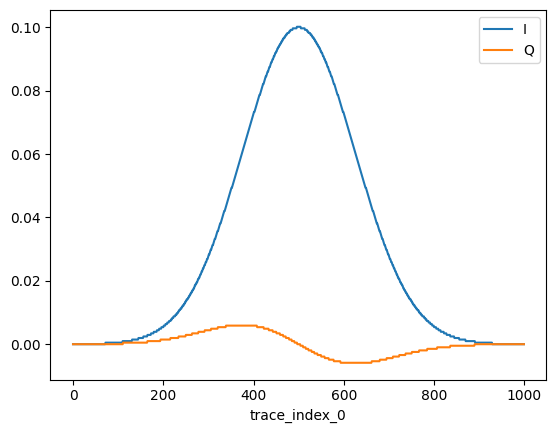

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1)

acquisition[0].real.plot(ax=axs, label="I")
acquisition[0].imag.plot(ax=axs, label="Q")

axs.set_title("")
axs.set_ylabel("")
axs.legend()
plt.show()

(sec-ssb)=
### Single-sideband integration acquisition

The single-sideband integration protocol involves integrating the complex input signal over a given time period. The integration weight is a square window, and this window's length is the same as the acquisition length. The signal is demodulated using the specified clock before the integration happens.

In this tutorial, we will send 4 square pulses out, and measure it in 4 separate bins, indexed by all combinations of `acq_channel=0,1` and `acq_index_<acq_channel>=0,1`. We will also send out purely real and imaginary pulses (or purely I and purely Q pulses), and observe that they appear as real and imaginary acquisitions. In the case of single-sideband integration the integration happens after demodulation.


Typically, different acquisition channels are usually set up to refer to different qubits. However, in our simple example, we only use a single qubit port-clock combination for both acquisition channels.

#### Setting up the schedule

Let's define how much time the pulse takes with `pulse_duration`. We define a separate parameter `acq_duration`, allowing the integration time to be larger than the duration of the pulse
(e.g., in case the `time_of_flight` was not yet calibrated).

In [15]:
pulse_duration = 120e-9
acq_duration = pulse_duration

We define a simple helper function that sends out the square pulse with `pulse_level` complex amplitude, and then measures it after `time_of_flight` seconds.

In [16]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations import IdlePulse, SquarePulse, SSBIntegrationComplex
from quantify_scheduler.enums import BinMode

schedule = Schedule("ssb_acquisition_tutorial")
schedule.add(IdlePulse(duration=1e-6))

def pulse_and_acquisition(pulse_level, acq_channel, acq_index, schedule, bin_mode=BinMode.AVERAGE):
    schedule.add(
        SquarePulse(
            duration=pulse_duration,
            amp=pulse_level,
            port="q0:res",
            clock="q0.ro",
        ),
        ref_pt="end",
        rel_time=1e-6,  # Idle time before the pulse is played
    )
    schedule.add(
        SSBIntegrationComplex(
            duration=acq_duration,
            port="q0:res",
            clock="q0.ro",
            acq_channel=acq_channel,
            acq_index=acq_index,
            bin_mode=bin_mode,
        ),
        ref_pt="start",
        rel_time=time_of_flight
    )

pulse_and_acquisition(pulse_level=0.125,  acq_channel=0, acq_index=0, schedule=schedule)
pulse_and_acquisition(pulse_level=0.125j, acq_channel=0, acq_index=1, schedule=schedule)
pulse_and_acquisition(pulse_level=0.25,   acq_channel=1, acq_index=0, schedule=schedule)
pulse_and_acquisition(pulse_level=0.25j,  acq_channel=1, acq_index=1, schedule=schedule)

Notice, that the amplitude is double in the case of `acq_channel=1` compared to `acq_channel=0`. Also, the amplitude is complex: in case `acq_index_<acq_channel>=0` the amplitude is real, and in case `acq_index_<acq_channel>=1` the amplitude is imaginary.

In [17]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData

dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0)
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)
dummy_data_0 = [
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=0),
        DummyBinnedAcquisitionData(data=(0, 16), thres=0, avg_cnt=0),
]
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="0", data=dummy_data_0)
dummy_data_1 = [
        DummyBinnedAcquisitionData(data=(32, 0), thres=0, avg_cnt=0),
        DummyBinnedAcquisitionData(data=(0, 32), thres=0, avg_cnt=0),
]
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="1", data=dummy_data_1)

Let's compile the schedule.

In [18]:
from quantify_scheduler import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=device.generate_compilation_config())

#### Running the schedule, retrieving acquisition

Let's run the schedule, and retrieve the acquisitions.

In [19]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [20]:
acquisition

<xarray.Dataset> Size: 96B
Dimensions:      (acq_index_0: 2, acq_index_1: 2)
Coordinates:
  * acq_index_0  (acq_index_0) int64 16B 0 1
  * acq_index_1  (acq_index_1) int64 16B 0 1
Data variables:
    0            (acq_index_0) complex128 32B (0.13333333333333333+0j) 0.1333...
    1            (acq_index_1) complex128 32B (0.26666666666666666+0j) 0.2666...

There are now two {class}`xarray.DataArray`s in this {class}`xarray.Dataset`. These correspond to `acq_channel=0` and `acq_channel=1`. Both of these `DataArrays` have the following two dimensions: `acq_index_<acq_channel>` and `repetition`. Because the schedule was run only once, `repetition=0` for all values.

As expected, the single side band integration produced a single complex number in each bin. One purely real value in `acq_index_<acq_channel>=0` and one purely imaginary value in `acq_index_<acq_channel>=1`. Notice how these values are twice as much for `acq_index_<acq_channel>=1` as compared to those for `acq_index_<acq_channel>=0`.

#### Bin modes and repetitions

`quantify-scheduler` offers two kinds of bin modes, that deal with repeated schedules:

- **Average** bin mode: Enables repeated measurements and averaging for reduced errors.
- **Append** bin mode: Allows repeating measurements and retrieving data for each repetition individually.

```{note}
`QuantumDevice.cfg_sched_repetitions` has no effect in running via {class}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator` directly;
it only has effect when using {class}`~quantify_scheduler.gettables.ScheduleGettable` (also see {ref}`Tutorial: ScheduleGettable <sec-tutorial-schedulegettable-repetitions>`).
```

```{note}
Important: Mixing bin modes is not allowed, all bin modes must be the same for each acquisition in one schedule.
```

To determine the number of times you want `quantify-scheduler` to execute the schedule, you can set the `repetitions` argument or attribute for the `Schedule` object. By specifying a value for `repetitions`, you can control the number of times the schedule will run. For example, if you set `repetitions` to `8`, the following code snippet demonstrates a schedule that would execute eight times:

```{code-block} ipython3
schedule = Schedule("Repeated schedule", repetitions=8)
```

##### Average bin mode

To specify which bin mode you would like to use, set the `bin_mode` argument for each acquisition operation. By default, they are set to `BinMode.AVERAGE`.

```{code-block} ipython3
from quantify_scheduler.enums import BinMode

schedule.add(
    SSBIntegrationComplex(
        duration=acq_duration,
        port="q0:res",
        clock="q0.ro",
        acq_channel=acq_channel,
        acq_index=acq_index,
        bin_mode=BinMode.AVERAGE,
    )
)
```

```{note}
Trace acquisitions only work with average bin mode. Integration-type acquisitions can be used with append bin mode too.
```

##### Append bin mode

Let's create a schedule which is run 3 times in a row in append mode.

In [21]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations import IdlePulse, SquarePulse, SSBIntegrationComplex
from quantify_scheduler.enums import BinMode

schedule = Schedule("append_tutorial", repetitions=3)
schedule.add(IdlePulse(duration=1e-6))

pulse_and_acquisition(pulse_level=0.125, acq_channel=0, acq_index=0, schedule=schedule, bin_mode=BinMode.APPEND)
pulse_and_acquisition(pulse_level=0.25,  acq_channel=0, acq_index=1, schedule=schedule, bin_mode=BinMode.APPEND)

In [22]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData

dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0)
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)
dummy_data_0 = [
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=0),
        DummyBinnedAcquisitionData(data=(32, 0), thres=0, avg_cnt=0),
] * 3
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="0", data=dummy_data_0)

Let's compile the schedule.

In [23]:
from quantify_scheduler import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=device.generate_compilation_config())

And retrieve the acquisitions

In [24]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [25]:
acquisition

<xarray.Dataset> Size: 112B
Dimensions:      (acq_index_0: 2, repetition: 3)
Coordinates:
  * acq_index_0  (acq_index_0) int64 16B 0 1
Dimensions without coordinates: repetition
Data variables:
    0            (repetition, acq_index_0) complex128 96B (0.1333333333333333...

Notice, that now we have `3*2` acquisition values, as expected: with 3 repetitions, and for each repetition 2 acquisitions. Let's select the values for the second run.

In [26]:
acquisition[0].sel(repetition=1)

<xarray.DataArray 0 (acq_index_0: 2)> Size: 32B
array([0.13333333+0.j, 0.26666667+0.j])
Coordinates:
  * acq_index_0  (acq_index_0) int64 16B 0 1
Attributes:
    acq_protocol:  SSBIntegrationComplex

As expected, it has only two values, and the value of `acq_index_<acq_channel>=1` is double that of `acq_index_<acq_channel>=0`.

(sec-weighted-ssb)=
### Weighted single-sideband integration acquisition

_Weighted_ single-sideband (SBB) integration works almost the same as regular SSB integration. In weighted SSB integration, the acquired (demodulated) data points are multiplied together with points of a _weight_ waveform. The relevant acquisition class is {class}`~quantify_scheduler.operations.acquisition_library.NumericalSeparatedWeightedIntegration`.

The weights can be provided in the form of two numerical arrays, `weights_a` for the I-path and `weights_b` for the Q-path of the acquisition signal, together with the sampling rate (`weights_sampling_rate`) of these arrays. The `quantify-scheduler` hardware backends will resample the weights if needed to match the hardware sampling rate. Note that the length of the weights arrays determines the integration time of the acquisition. All values in the weight arrays must be in the range `[-1, 1]`.

As an example, we create a simple schedule using weighted integration below. The setup is the same as in the {ref}`sec-ssb` section. To show the effect of weighted integration, we will measure a square pulse three times with different weights:

* an array with all values `1.0` (which is the same as a normal SSB integration),
* an array with all values `0.5`,
* a sine function with amplitude `1.0` and an average of `0.0`.

In [27]:
from quantify_scheduler.operations import NumericalSeparatedWeightedIntegration


schedule = Schedule("weighted_acquisition_tutorial")
schedule.add(IdlePulse(duration=1e-6))


def add_pulse_and_weighted_acquisition_to_schedule(
    weights_a,
    weights_b,
    acq_index,
    schedule,
    acq_channel=0,
    weights_sampling_rate=1e9,
    bin_mode=BinMode.APPEND,
):
    schedule.add(
        SquarePulse(
            duration=1e-6,
            amp=0.5,
            port="q0:res",
            clock="q0.ro",
        ),
        ref_pt="end",
        rel_time=1e-6,  # Idle time before the pulse is played
    )
    schedule.add(
        NumericalSeparatedWeightedIntegration(
            port="q0:res",
            clock="q0.ro",
            weights_a=weights_a,
            weights_b=weights_b,
            weights_sampling_rate=weights_sampling_rate,
            acq_channel=acq_channel,
            acq_index=acq_index,
            bin_mode=bin_mode,
        ),
        ref_pt="start",
        rel_time=time_of_flight,
    )
    return schedule


square_weights = np.ones(1000)
add_pulse_and_weighted_acquisition_to_schedule(
    weights_a=square_weights,
    weights_b=square_weights,
    weights_sampling_rate=1e9,
    acq_channel=0,
    acq_index=0,
    schedule=schedule,
)

half_value_weights = square_weights / 2
add_pulse_and_weighted_acquisition_to_schedule(
    weights_a=half_value_weights,
    weights_b=square_weights,
    acq_index=1,
    schedule=schedule,
)

sine_weights = np.sin(2 * np.pi * np.linspace(0, 1, 1000))
add_pulse_and_weighted_acquisition_to_schedule(
    weights_a=sine_weights,
    weights_b=square_weights,
    acq_index=2,
    schedule=schedule,
)

Schedule "weighted_acquisition_tutorial" containing (5) 7  (unique) operations.

Note that the lengths of the arrays are all 1000. With the specified sampling rate, this corresponds to an acquisition duration of 1 μs.

In [28]:
dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0)
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)
dummy_data_0 = [
    DummyBinnedAcquisitionData(data=(0.5, 0), thres=0, avg_cnt=0),
    DummyBinnedAcquisitionData(data=(0.25, 0), thres=0, avg_cnt=0),
    DummyBinnedAcquisitionData(data=(0, 0), thres=0, avg_cnt=0),
]
cluster.set_dummy_binned_acquisition_data(
    slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="0", data=dummy_data_0
)

Let's compile the schedule.

In [29]:
from quantify_scheduler import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(
    schedule=schedule, config=device.generate_compilation_config()
)

And retrieve the acquisitions

In [30]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [31]:
acquisition

<xarray.Dataset> Size: 72B
Dimensions:      (acq_index_0: 3, repetition: 1)
Coordinates:
  * acq_index_0  (acq_index_0) int64 24B 0 1 2
Dimensions without coordinates: repetition
Data variables:
    0            (repetition, acq_index_0) complex128 48B (0.4999998806742098...

The data set contains three data points corresponding to the acquisitions we scheduled. The first acquisition with the maximum amplitude (1.0) square weights shows the highest voltage, the second one with the weights halved also shows half the voltage. The third, corresponding to the sinusoidal weights with an average of 0, shows 0 as expected.

As a final note, weighted integration can also be scheduled at the {ref}`gate-level <Gate-level acquisitions>` by specifying `"NumericalSeparatedWeightedIntegration"` as the acquisition protocol and providing the weights in the quantum device element {attr}`.BasicTransmonElement.measure`, for example:

```
<qubit>.measure.acq_weights_a(sine_weights)
<qubit>.measure.acq_weights_b(square_weights)
```

(thresholded_acquisition_explanation)=
### Thresholded acquisition
With thresholded acquisition, we can map a complex input signal to either a 0 or a 1, by comparing the data to a threshold value. It is similar to the {ref}`single-sideband integration protocol <sec-ssb>` described above, but after integration the I-Q data points are first rotated by an angle and then compared to a threshold value to assign the results to either a "0" or to a "1". See the illustration below.

```{figure} /images/thresholded_acquisition_explanation.svg
:align: center

Illustration of the acquisition threshold.
```

Here the threshold line is controlled by the qubit settings: `acq_rotation` and `acq_threshold`. By default (left figure) we have `acq_rotation=0` and `acq_threshold=0`, where every measured (integrated) data point with I<0 is assigned the state "0", and the remaining data points are assigned the state "1". The first setting, `acq_rotation`, rotates the threshold line by an angle in degrees (0 - 360), clockwise. The second setting, `acq_threshold`, sets the threshold that is compared to the rotated integrated acquisition result.

```{admonition} Note
Thresholded acquisition is currently only supported by the Qblox backend.

The `qblox-instruments` parameter `thresholded_acq_threshold` corresponds to a voltage obtained from an integrated acquisition, **before** normalizing with respect to the integration time.
The `quantify-scheduler` parameter `acq_threshold` corresponds to an acquired voltage **after** normalizing with respect to the integration time (e.g. as obtained from a single side band integration).
```

#### Setting up the schedule

Let's imagine a simple experiment where we prepare a qubit in the ground state, apply a {math}`\pi`-rotation and then measure the outcome.
This experiment is then repeated 200 times. The corresponding schedule would look like:

In [32]:
from quantify_scheduler.operations import Reset, X

pulse_duration = 1e-6
acq_duration = pulse_duration
pulse_level = 0.25

schedule = Schedule("ssb_acquisition", repetitions=200)

schedule.add(Reset("q0"))
schedule.add(X("q0"))

schedule.add(
    SquarePulse(
        duration=pulse_duration,
        amp=pulse_level,
        port="q0:res",
        clock="q0.ro",
    ),
    ref_pt="end",
    rel_time=1e-6,  # Idle time before the pulse is played
)
schedule.add(
    SSBIntegrationComplex(
        duration=acq_duration,
        port="q0:res",
        clock="q0.ro",
        acq_channel=0,
        acq_index=0,
        bin_mode=BinMode.APPEND,
    ),
    ref_pt="start",
    rel_time=time_of_flight
)

{'name': '312ba19a-58ca-4ad6-b926-81309ce4d2cc', 'operation_id': '-4792882696387332517', 'timing_constraints': [{'rel_time': 1.48e-07, 'ref_schedulable': None, 'ref_pt_new': None, 'ref_pt': 'start'}], 'label': '312ba19a-58ca-4ad6-b926-81309ce4d2cc'}

In [33]:
from scipy.stats import norm
import numpy as np
np.random.seed(0)

x = 0.1 + 0.03j
y = -0.15 - 0.1j
s = 0.03

i = np.concatenate(
    (norm.rvs(np.real(x), s, 100),
    norm.rvs(np.real(y), s, 100))
)
q = np.concatenate((
    norm.rvs(np.imag(x), s, 100),
    norm.rvs(np.imag(y), s, 100)
))

b = -np.real(y-x)/np.imag(y-x)
a = -1/2*np.real(x+y)*b
rot = np.arctan(-b)-np.pi/2
threshold = -a*b/np.sqrt(1+b*b)

dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)

dummy_data_0 = [
        DummyBinnedAcquisitionData(data=(1e3*a, 1e3*b), thres=0, avg_cnt=0)
        for a, b in zip(i,q)
]
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1, acq_index_name="0", data=dummy_data_0)

Next, after compiling the schedule and retrieving the acquisitions from the hardware,

In [34]:
compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=device.generate_compilation_config())

instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

we might obtain the following data:

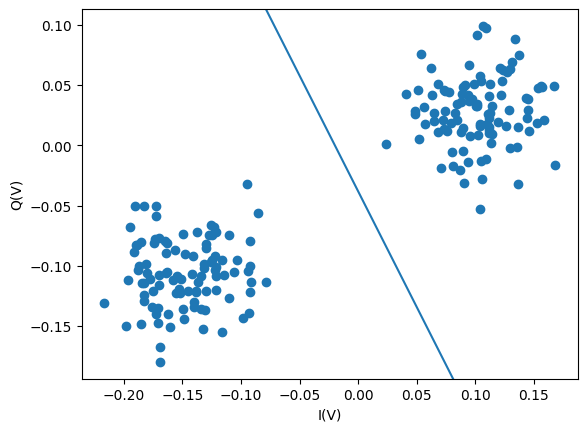

In [35]:
threshold, rotation = -0.043, 332.5
plt.scatter(np.real(acquisition[0]), np.imag(acquisition[0]))
plt.axline((0, threshold*np.cos(np.deg2rad(rotation))), slope = 1/np.tan(np.deg2rad(rotation)))
plt.xlabel("I(V)")
plt.ylabel("Q(V)")
plt.show()

Where the two clusters of data correspond to the two qubit states of `q0`: {math}`|0\rangle` and {math}`|1\rangle`. The threshold line was chosen as the bisector of the centroids of the two clusters of data.

To assign each cluster to one state, we can set the qubit parameters {attr}`BasicTransmonElement.measure.acq_threshold` and {attr}`BasicTransmonElement.measure.acq_rotation` and run the experiment with the `ThresholdedAcquisition` protocol.

In [36]:
from quantify_scheduler.operations import ThresholdedAcquisition

# Set the threshold values
transmon0.measure.acq_threshold(-0.043)
transmon0.measure.acq_rotation(332.5)

thres_acq_sched = Schedule("thresholded_acquisition", repetitions=200)
thres_acq_sched.add(Reset("q0"))
thres_acq_sched.add(X("q0"))

thres_acq_sched.add(
    SquarePulse(
        duration=pulse_duration,
        amp=pulse_level,
        port="q0:res",
        clock="q0.ro",
    ),
    ref_pt="end",
    rel_time=1e-6,  # Idle time before the pulse is played
)
thres_acq_sched.add(
    ThresholdedAcquisition(
        duration=acq_duration,
        port="q0:res",
        clock="q0.ro",
        acq_channel=0,
        acq_index=0,
        bin_mode=BinMode.APPEND,
    ),
    ref_pt="start",
    rel_time=time_of_flight
)

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=thres_acq_sched, config=device.generate_compilation_config())

instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()
acquisition

<xarray.Dataset> Size: 808B
Dimensions:      (acq_index_0: 1, repetition: 200)
Coordinates:
  * acq_index_0  (acq_index_0) int64 8B 0
Dimensions without coordinates: repetition
Data variables:
    0            (repetition, acq_index_0) int32 800B 0 0 0 0 0 0 ... 0 0 0 0 0

In [37]:
# qblox-instruments doesn't support retrieving dummy thresholded data yet.
import xarray as xr
array = np.concatenate((np.ones(100), np.zeros(100)))
np.random.shuffle(array)
acquisition[0] = xr.DataArray(array.reshape((200,1)), dims=['repetitions', 'acq_index_0'])
acquisition

<xarray.Dataset> Size: 2kB
Dimensions:      (acq_index_0: 1, repetitions: 200)
Coordinates:
  * acq_index_0  (acq_index_0) int64 8B 0
Dimensions without coordinates: repetitions
Data variables:
    0            (repetitions, acq_index_0) float64 2kB 1.0 0.0 1.0 ... 1.0 0.0

The retrieved dataset contains the integrated acquired results and contains in this case equal amounts of 0s and 1s (corresponding to the two clusters).

In [38]:
print("state 0: ", sum(acquisition[0].values==0))
print("state 1: ", sum(acquisition[0].values==1))

state 0:  [100]
state 1:  [100]


The above schedule was run in the bin mode `BinMode.APPEND`, rerunning the schedule with `BinMode.AVERAGE` will average the thresholded values and in this case produce the single number, 0.5.

(sec-acquisitions-trigger-count)=
### Trigger count acquisition

The trigger count acquisition protocol is used for measuring how many times the input signal goes over some limit.
This protocol is used, for example, in the case of an NV center type of qubit, or other types of qubit, where counting the number of photons (indirectly as an electrical signal) is important.

The trigger count protocol is currently only implemented for the Qblox backend, and it is available on two module types: the **QRM** (baseband) and the **QTM**. Please also see {ref}`sec-qblox-acquisition-details` for more information on Qblox module-specific behavior of this operation.

The {class}`~quantify_scheduler.operations.acquisition_library.TriggerCount` protocol offers three bin modes: **append**, **sum**, and **distribution**. The **distribution** mode can only be used with the QRM, while the **append** and **sum** mode can be used with both the QRM and the QTM.

The **append** bin mode is quite similar to the {ref}`single-sideband integration protocol <sec-ssb>` case. Instead of the integrated acquisition result, the data will consist of the total number of triggers counted during each acquisition.
Let's consider an example where we execute a schedule three times:

- during the 1st run, three triggers are acquired,
- during the 2nd run, one trigger is acquired,
- during the 3rd run, one trigger is acquired.

The result would then be the list `[3, 1, 1]` for acquisition index 0.

In the **sum** bin mode, counts in repeated acquisitions with the same acquisition index are simply accumulated. Given the same experiment as above, the returned amount of counts for acquisition index 0 would be `5` with this bin mode.

In the **distribution** bin mode, the result is a _distribution_ that maps the trigger count numbers to the number of occurrences of each trigger count number.
This provides insights into the overall occurrence of triggers when running the acquisition multiple times. Let's consider the exact same experimental example as above, where a schedule is executed three times.

The overall distribution of triggers would be: trigger count of 1 occurred twice, and trigger count of 3 occurred once. Hence, the resulting dictionary would be: `{1: 2, 3: 1}`.
The dictionary notation shows the number of triggers as keys and their corresponding frequencies as values.

Note, the threshold is set for the QRM via the field {class}`~quantify_scheduler.backends.types.qblox.SequencerOptions.ttl_acq_threshold` in {ref}`sec-qblox-sequencer-options`, while for the QTM this threshold is set via the field `in_threshold_primary` in the {ref}`sec-qblox-digitization-thresholds` hardware option.

#### Setup and schedule

In this tutorial we will explain how **distribution bin mode** works in the {class}`~quantify_scheduler.operations.acquisition_library.TriggerCount` protocol (also see the introduction above).
We create a schedule that consists of an acquisition operation that measures the trigger signals.
In this tutorial we assume trigger signals are generated from an external source (we do not generate these from the control hardware).

In [39]:
from quantify_scheduler import BasicElectronicNVElement, GenericInstrumentCoordinatorComponent, MockLocalOscillator, QuantumDevice

nv_device = QuantumDevice(name="nv_device")
qe0 = BasicElectronicNVElement("qe0")
qe0.clock_freqs.ge0.set(470.4e12)
qe0.clock_freqs.spec.set(2.85e9)
nv_device.add_element(qe0)
nv_device.instr_instrument_coordinator("instrument_coordinator")

red_laser = MockLocalOscillator("red_laser")
ic_red_laser = GenericInstrumentCoordinatorComponent(red_laser)
instrument_coordinator.add_component(ic_red_laser)

hardware_cfg_trigger_count = config = {
    "config_type": "quantify_scheduler.backends.qblox_backend.QbloxHardwareCompilationConfig",
    "hardware_description": {
        "cluster0": {
            "instrument_type": "Cluster",
            "modules": {
                1: {
                    "instrument_type": "QRM"
                }
            },
            "ref": "internal"
        },
        "optical_mod_red_laser": {
            "instrument_type": "OpticalModulator"
        },
        "red_laser": {
            "instrument_type": "LocalOscillator",
            "power": 1
        }
    },
    "hardware_options": {
        "modulation_frequencies": {
            "qe0:optical_readout-qe0.ge0": {
                "lo_freq": None,
                "interm_freq": 50000000.0
            }
        },
        "sequencer_options": {
            "qe0:optical_readout-qe0.ge0": {
                "ttl_acq_threshold": 0.5
            }
        }
    },
    "connectivity": {
        "graph": [
            ("cluster0.module1.real_input_0", "optical_mod_red_laser.if"),
            ("red_laser.output", "optical_mod_red_laser.lo"),
            ("optical_mod_red_laser.out", "qe0:optical_readout")
        ]
    }
}

nv_device.hardware_config(hardware_cfg_trigger_count)

The hardware should run the trigger count acquisition 3 times, and the schedule contains one trigger count acquisition, we therefore set `repetitions=3` for the schedule.
The input signals are the following: the first time the schedule runs there are 3 trigger signals, the second time there is 1 trigger signal, and third time there is again 1 trigger signal.

In [40]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations import IdlePulse, SquarePulse, TriggerCount
from quantify_scheduler.enums import BinMode

acq_duration = 120e-9

schedule = Schedule("trigger_count_acquisition_tutorial", repetitions=3)
schedule.add(IdlePulse(duration=1e-6))

schedule.add(
    TriggerCount(
        t0=0,
        duration=acq_duration,
        port="qe0:optical_readout",
        clock="qe0.ge0",
        acq_channel=0,
        bin_mode=BinMode.AVERAGE,
    )
)

/usr/local/lib/python3.9/site-packages/quantify_scheduler/operations/acquisition_library.py:851: FutureWarning: average is deprecated for the TriggerCount acquisition protocol, and will be removed in quantify-scheduler>=0.24.0. Use distribution instead, which has the same effect.
  warnings.warn(


{'name': 'cec273fd-2d32-45c7-9ad0-433a18962692', 'operation_id': '-649831095655206', 'timing_constraints': [{'rel_time': 0, 'ref_schedulable': None, 'ref_pt_new': None, 'ref_pt': None}], 'label': 'cec273fd-2d32-45c7-9ad0-433a18962692'}

It's important in using {class}`~quantify_scheduler.operations.acquisition_library.TriggerCount` acquisitions that the acquisition channel is identical for all acquisitions in a schedule,
leading to a single distribution in case of average bin mode (and a single list in case of append bin mode).
In this example, if instead there would be 3 acquisitions in the schedule, and all of the acquisition channels were different and then only running the schedule once,
we would get 3 separate distributions (one per acquisition channel).

In [41]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData

dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0)
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)
dummy_data_0 = [
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=3),
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=1),
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=1),
]
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="0", data=dummy_data_0)

Let's compile the schedule.

In [42]:
from quantify_scheduler import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=nv_device.generate_compilation_config())

#### Running the schedule, retrieving acquisition

Let's run the schedule, and retrieve the acquisitions.

In [43]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [44]:
acquisition

<xarray.Dataset> Size: 40B
Dimensions:     (repetition: 1, counts: 2)
Coordinates:
  * repetition  (repetition) int64 8B 0
  * counts      (counts) int64 16B 1 3
Data variables:
    0           (repetition, counts) int64 16B 2 1

There were three trigger acquisitions overall. In the first acquisition 3 triggers were sent-out, and in the second and third case, only one. So, we expect to see that one trigger was measured twice, and 3 triggers were measured only once. The data shows exactly this. At `acq_channel=0` (corresponding to the `0` key in the `Dataset`) the values are `2` and `1`, with `counts` for `1` and `3` respectively.


(sec-acquisitions-thresholded-trigger-count)=
### Thresholded trigger count acquisition

The thresholded trigger count acquisition protocol also counts rising edges of the input signal, like the trigger count acquisition, and subsequently compares the result (the number of counts) to a counts threshold. The threshold comparison result (False (0), or True (1)) can be retrieved directly, and can also be used to conditionally execute other instructions. For the latter, you would use the {class}`~quantify_scheduler.operations.control_flow_library.ConditionalOperation` in the same way as described in {ref}`sec-tutorial-conditional-reset`. You can expand the section below for an example schedule.

In [45]:
from quantify_scheduler import Schedule
from quantify_scheduler.enums import TriggerCondition
from quantify_scheduler.operations import (
    ConditionalOperation,
    IdlePulse,
    ThresholdedTriggerCount,
    X,
)


schedule = Schedule("Conditional X gate")
schedule.add(
    ThresholdedTriggerCount(
        port="qe0:optical_readout",
        clock="qe0.ge0",
        duration=1e-6,
        threshold=10,
        feedback_trigger_label="qe0",
        feedback_trigger_condition=TriggerCondition.LESS_THAN,
    )
)
schedule.add(
    ConditionalOperation(body=X("qe0"), qubit_name="qe0"),
    rel_time=364e-9,
)
schedule.add(IdlePulse(4e-9))

{'name': 'b5b76674-5d09-43cb-b3e2-36faa921de29', 'operation_id': '-8941877968262116346', 'timing_constraints': [{'rel_time': 0, 'ref_schedulable': None, 'ref_pt_new': None, 'ref_pt': None}], 'label': 'b5b76674-5d09-43cb-b3e2-36faa921de29'}

The thresholded trigger count protocol is currently only implemented for the Qblox backend, and it is available on two module types: the **QRM** (baseband) and the **QTM**. Please also see {ref}`sec-qblox-acquisition-details` for more information on Qblox module-specific behavior of this operation.

The protocol only works with the **append** bin mode. This means each acquisition result will appear in a separate bin.

Note, the analog threshold for registering a single count is set for the QRM via the field {class}`~quantify_scheduler.backends.types.qblox.SequencerOptions.ttl_acq_threshold` in {ref}`sec-qblox-sequencer-options`, while for the QTM this threshold is set via the field `in_threshold_primary` in the {ref}`sec-qblox-digitization-thresholds` hardware option.

#### Setup and schedule

In this tutorial we will explain the basic usage of the {class}`~quantify_scheduler.operations.acquisition_library.ThresholdedTriggerCount` protocol (also see the introduction above).
We create a schedule that consists of an acquisition operation that measures the trigger signals.
In this tutorial we assume trigger signals are generated from an external source (we do not generate these from the control hardware).

In [46]:
from quantify_scheduler import BasicElectronicNVElement, GenericInstrumentCoordinatorComponent, MockLocalOscillator, QuantumDevice

hardware_cfg_trigger_count = config = {
    "config_type": "quantify_scheduler.backends.qblox_backend.QbloxHardwareCompilationConfig",
    "hardware_description": {
        "cluster0": {
            "instrument_type": "Cluster",
            "modules": {
                1: {
                    "instrument_type": "QRM"
                }
            },
            "ref": "internal"
        },
        "optical_mod_red_laser": {
            "instrument_type": "OpticalModulator"
        },
        "red_laser": {
            "instrument_type": "LocalOscillator",
            "power": 1
        }
    },
    "hardware_options": {
        "modulation_frequencies": {
            "qe0:optical_readout-qe0.ge0": {
                "lo_freq": None,
                "interm_freq": 50000000.0
            }
        },
        "sequencer_options": {
            "qe0:optical_readout-qe0.ge0": {
                "ttl_acq_threshold": 0.5
            }
        }
    },
    "connectivity": {
        "graph": [
            ("cluster0.module1.real_input_0", "optical_mod_red_laser.if"),
            ("red_laser.output", "optical_mod_red_laser.lo"),
            ("optical_mod_red_laser.out", "qe0:optical_readout")
        ]
    }
}

nv_device.hardware_config(hardware_cfg_trigger_count)

The schedule contains one trigger count acquisition, and we will set `repetitions=3` so that there will be three acquisitions done in total.
The input signals are the following: The first time the schedule runs, there are 3 trigger signals. The second time there is 1 trigger signal. And the third time there is again 1 trigger signal. 
The **counts threshold** is set to 2 counts.

Note that for usage with conditional operations, there are also the parameters `feedback_trigger_condition` and `feedback_trigger_label`. The former controls whether the conditional instructions play upon counting less than the threshold (value {class}`~quantify_scheduler.enums.TriggerCondition.LESS_THAN`), or equal to/more than the threshold (value {class}`~quantify_scheduler.enums.TriggerCondition.GREATER_THAN_EQUAL_TO`). The latter, `feedback_trigger_label`, links acquisition operations and conditional operations with each other if they have the same label.

In [47]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations import IdlePulse, SquarePulse, ThresholdedTriggerCount
from quantify_scheduler.enums import BinMode

acq_duration = 120e-9

schedule = Schedule("trigger_count_acquisition_tutorial", repetitions=3)
schedule.add(IdlePulse(duration=1e-6))

schedule.add(
    ThresholdedTriggerCount(
        t0=0,
        duration=acq_duration,
        threshold=2,
        port="qe0:optical_readout",
        clock="qe0.ge0",
        acq_channel=0,
        bin_mode=BinMode.APPEND,
    )
)

{'name': '9c2654de-768b-4885-b783-50996b30a766', 'operation_id': '-1813047988198168317', 'timing_constraints': [{'rel_time': 0, 'ref_schedulable': None, 'ref_pt_new': None, 'ref_pt': None}], 'label': '9c2654de-768b-4885-b783-50996b30a766'}

In [48]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData

dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0)
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)
dummy_data_0 = [
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=3),
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=1),
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=1),
]
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="0", data=dummy_data_0)

Let's compile the schedule.

In [49]:
from quantify_scheduler import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=nv_device.generate_compilation_config())

#### Running the schedule, retrieving acquisition

Let's run the schedule, and retrieve the acquisitions.

In [50]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [51]:
acquisition

<xarray.Dataset> Size: 56B
Dimensions:      (repetition: 1, acq_index_0: 3)
Coordinates:
  * repetition   (repetition) int64 8B 0
  * acq_index_0  (acq_index_0) int64 24B 0 1 2
Data variables:
    0            (repetition, acq_index_0) int64 24B 1 0 0

There were three trigger acquisitions overall. In the first acquisition 3 triggers were sent-out, and in the second and third case, only one. With a threshold of 2 counts, we expect to see an array of `[1, 0, 0]`, meaning only the first acquisition was above the threshold.

(sec-acquisitions-dual-thresholded-trigger-count)=
### Dual thresholded trigger count acquisition

Just like the `ThresholdedTriggerCount`, this acquisition protocol can be used together with the {class}`~quantify_scheduler.operations.control_flow_library.ConditionalOperation` to execute instructions based on the threshold comparison result, in the same way as described in {ref}`sec-tutorial-conditional-reset`. With `DualThresholdedTriggerCount`, there are 2 thresholds you can pass and 4 possible results:

- "low" when `counts < low_threshold`,
- "mid" when `low_threshold <= counts < high_threshold`,
- "high" when `counts >= high_threshold`,
- "invalid" when the counts are invalid (can occur in extremely rare cases, for example when the counter overflows).

In the returned acquisition data, only the raw counts are present.

You can use any number of the possible threshold comparison results by providing an appropriate label (`"label_<type>"` where type is one of "low", "mid", "high", "invalid") as an argument, and using that same label for a `ConditionalOperation`.

The thresholded trigger count protocol is currently only implemented for the Qblox backend, and it is available only on the **QTM**. Please also see {ref}`sec-qblox-acquisition-details` for more information on Qblox module-specific behavior of this operation.

The protocol only works with the **append** bin mode. This means each acquisition result will appear in a separate bin.

Note, the analog threshold for registering a single count is set via the field `in_threshold_primary` in the {ref}`sec-qblox-digitization-thresholds` hardware option.

#### Setup and schedule

In this tutorial we will explain the basic usage of the {class}`~quantify_scheduler.operations.acquisition_library.DualThresholdedTriggerCount` protocol (also see the introduction above).
We create a schedule that consists of an acquisition operation that measures the trigger signals, and a conditional operation just as an example (though we will not be able to show the output of that).
In this tutorial we assume trigger signals are generated from an external source (we do not generate these from the control hardware).

In [52]:
from quantify_scheduler import BasicElectronicNVElement, GenericInstrumentCoordinatorComponent, MockLocalOscillator, QuantumDevice

hardware_cfg_trigger_count = config = {
    "config_type": "quantify_scheduler.backends.qblox_backend.QbloxHardwareCompilationConfig",
    "hardware_description": {
        "cluster0": {
            "instrument_type": "Cluster",
            "modules": {
                2: {
                    "instrument_type": "QTM"
                },
                3: {
                    "instrument_type": "QCM_RF"
                }
            },
            "ref": "internal"
        },
    },
    "hardware_options": {
        "modulation_frequencies": {
            "qe0:mw-qe0.spec": {
                "lo_freq": 2.8e9,
                "interm_freq": 50000000.0
            }
        },
        "digitization_thresholds": {
            "qe0:optical_readout-qe0.ge0": {
                "in_threshold_primary": 0.5
            }
        }
    },
    "connectivity": {
        "graph": [
            ("cluster0.module2.digital_input_0", "qe0:optical_readout"),
            ("cluster0.module3.complex_output_0", "qe0:mw")
        ]
    }
}

nv_device.hardware_config(hardware_cfg_trigger_count)

The schedule contains one trigger count acquisition, and we will set `repetitions=3` so that there will be three acquisitions done in total.
The input signals are the following: The first time the schedule runs, there are 12 trigger signals. The second time there are 7 trigger signals. And the third time there are again 3 trigger signals. 
The **threshold_low** is set to 5 counts and **threshold_high** to 10 counts.

In [53]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations import (
    ConditionalOperation,
    DualThresholdedTriggerCount,
    IdlePulse,
    SquarePulse,
)
from quantify_scheduler.enums import BinMode

schedule = Schedule("dual_trigger_count_acquisition_tutorial", repetitions=3)

trigcnt = schedule.add(
    DualThresholdedTriggerCount(
        port="qe0:optical_readout",
        clock="digital",
        duration=10e-6,
        threshold_low=5,
        threshold_high=10,
        label_mid="qe0_mid",
    )
)

cond_body = Schedule("cond_body")
cond_body.add(SquarePulse(port="qe0:mw", clock="qe0.spec", amp=0.5, duration=10e-6))

schedule.add(
    ConditionalOperation(body=cond_body, qubit_name="qe0_mid"),
    ref_op=trigcnt,
    rel_time=1000e-9,
)
schedule.add(IdlePulse(4e-9))

{'name': 'c233e696-90c6-4acc-b597-25b7abe4efaa', 'operation_id': '-8941877968262116346', 'timing_constraints': [{'rel_time': 0, 'ref_schedulable': None, 'ref_pt_new': None, 'ref_pt': None}], 'label': 'c233e696-90c6-4acc-b597-25b7abe4efaa'}

In [54]:
dummy_data = {
        "0": {
            "index": 0,
            "acquisition": {
                "bins": {
                    "count": [
                        12.0,
                        7.0,
                        3.0,
                    ],
                    "timedelta": [
                        1898975.0,
                        326098.0,
                        809414.0,
                    ],
                    "threshold": [1.0, 1.0, 0.0],
                    "avg_cnt": [1, 1, 1],
                }
            },
        }
    }

cluster.module2.get_acquisitions = lambda _seq: dummy_data

# mock this call because the assembler is not implemented.
cluster.module2.sequencer0.sequence.set = lambda _sequence: None

Let's compile the schedule.

In [55]:
from quantify_scheduler import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=nv_device.generate_compilation_config())

#### Running the schedule, retrieving acquisition

Let's run the schedule, and retrieve the acquisitions.

In [56]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [57]:
acquisition

<xarray.Dataset> Size: 56B
Dimensions:      (repetition: 1, acq_index_0: 3)
Coordinates:
  * repetition   (repetition) int64 8B 0
  * acq_index_0  (acq_index_0) int64 24B 0 1 2
Data variables:
    0            (repetition, acq_index_0) int64 24B 12 7 3

There were three trigger acquisitions overall. In the first acquisition 12 triggers were sent-out, in the second 7 and third case 3. We expect to see an array of `[12, 7, 3]`. The square pulse should have played only on the second repetition, when the number of counts was in between both thresholds.

(sec-acquisitions-timetag)=
### Timetag and TimetagTrace acquisitions

The Timetag and TimetagTrace acquisitions have their own dedicated tutorial: {ref}`sec-timetagging`.

## Gate-level acquisitions

In the previous section the schedule was defined on the hardware level, in terms of signals and pulses. In this section we will address the acquisitions in terms of qubits. To do that, first, we need to set up a qubit. See {ref}`sec-tutorial-ops-qubits` for an introduction to how to set up a schedule on the gate-level. Integration type acquisitions and trigger count acquisitions make sense on the gate-level, depending on the physical implementation of your qubit.

In this tutorial we will set up a simple single sideband integration acquisition on the gate-level. In the case of a transmon qubit, a {class}`~quantify_scheduler.operations.gate_library.Measure` gate first sends out an acquisition pulse, and then acquires the signal. The {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` stores the parameters of how the measurement gate is translated to device level operations by `quantify-scheduler`.

Let's see what is the effect of modifying the amplitude of the acquisition pulse on the acquisition result.
Let's set up the time of flight as before, but now on the {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice`, and set up the amplitude of the acquisition pulse, which is a square pulse in this case.

In [58]:
device.remove_element("q0")
transmon0.close()

In [59]:
time_of_flight = 148e-9
pulse_duration = 120e-9
acq_duration = pulse_duration

In [60]:
transmon0 = BasicTransmonElement("q0")
transmon0.clock_freqs.readout(6e9)
transmon0.measure.pulse_amp(0.125)
transmon0.measure.pulse_duration(pulse_duration)
transmon0.measure.acq_delay(time_of_flight)
transmon0.measure.integration_time(acq_duration)
transmon0.measure.acq_channel(2)
device.add_element(transmon0)

Similar to the previous setup, the pulse has an amplitude of 0.125 and matches the duration of the acquisition. In this case, `quantify-scheduler` will use the port `"<name>:res"` for both the acquisition pulse and acquisition itself, specifically `"q0:res"`.  Note, we set the `acq_channel` to `2` for the sake of the example.

The relevant hardware configuration is the following.

```{code-block} python
"portclock_configs": [
        {"port": "q0:res", "clock": "q0.ro", "interm_freq": 0},
    ]
```

### Creating and running the schedule

The qubit is now set up, and we can create the schedule.

In [61]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations import IdlePulse, Measure

schedule = Schedule("gate_level_ssb_acquisition_tutorial")

schedule.add(IdlePulse(duration=1e-6))

schedule.add(
    Measure("q0", acq_index=0),
    rel_time=1e-6,
)

{'name': '3aa3397b-ddef-4a94-8637-fea38de1a914', 'operation_id': '5514361165871605085', 'timing_constraints': [{'rel_time': 1e-06, 'ref_schedulable': None, 'ref_pt_new': None, 'ref_pt': None}], 'label': '3aa3397b-ddef-4a94-8637-fea38de1a914'}

In [62]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData

dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0)
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)
dummy_data_0 = [
        DummyBinnedAcquisitionData(data=(16, 0), thres=0, avg_cnt=0),
]
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="0", data=dummy_data_0)

Let's compile the schedule.

In [63]:
from quantify_scheduler import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=device.generate_compilation_config())

#### Running the schedule, retrieving acquisition

Let's run the schedule, and retrieve the acquisitions.

In [64]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [65]:
acquisition

<xarray.Dataset> Size: 24B
Dimensions:      (acq_index_2: 1)
Coordinates:
  * acq_index_2  (acq_index_2) int64 8B 0
Data variables:
    2            (acq_index_2) complex128 16B (0.13333333333333333+0j)

Notice, that the result is only one number at `acq_channel=2`.

#### Modifying the readout pulse amplitude

Let's see what the effect on the measurement is if we double the pulse amplitude of the readout pulse

In [66]:
device.remove_element("q0")

In [67]:
transmon0.measure.pulse_amp(0.25)
device.add_element(transmon0)

The amplitude of the read-out pulse is now `0.25`, double what it was.

In [68]:
from qblox_instruments import DummyBinnedAcquisitionData, DummyScopeAcquisitionData

dummy_slot_idx = 1
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0)
cluster.delete_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=1)
dummy_data_0 = [
        DummyBinnedAcquisitionData(data=(32, 0), thres=0, avg_cnt=0),
]
cluster.set_dummy_binned_acquisition_data(slot_idx=dummy_slot_idx, sequencer=0, acq_index_name="0", data=dummy_data_0)

Let's compile the schedule.

In [69]:
from quantify_scheduler import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(schedule=schedule, config=device.generate_compilation_config())

Let's run the schedule, and retrieve the acquisitions.

In [70]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

In [71]:
acquisition

<xarray.Dataset> Size: 24B
Dimensions:      (acq_index_2: 1)
Coordinates:
  * acq_index_2  (acq_index_2) int64 8B 0
Data variables:
    2            (acq_index_2) complex128 16B (0.26666666666666666+0j)

As you can see, because the measurement read-out pulse is now double in amplitude, the measured (acquired) value is now also double compared to the previous case.